# Описание датасета BraTS2020

## Общая информация

Название: Brain Tumor Segmentation (BraTS2020)
Описание: BraTS2020 представляет собой публичный датасет для задачи сегментации опухолей головного мозга по мультимодальным МРТ-сканам. Он содержит данные 369 пациентов с глиомами (высокой и низкой степени злокачественности). Каждый случай включает четыре типа МРТ-снимков и ручную разметку опухолей, выполненную экспертами-рентгенологами.

## Структура датасета

Датасет состоит из 369 отдельных папок томов?. Каждый том содержит следующие файлы:

*   **FLAIR (Fluid Attenuated Inversion Recovery):** Один из типов МРТ, чувствительный к наличию жидкости, что полезно для выявления отека вокруг опухоли.
*   **T1 (T1-weighted):** Базовое взвешенное изображение.
*   **T1CE (T1-weighted Contrast Enhanced):** T1-взвешенное изображение после введения контрастного вещества, которое помогает выделить участки с нарушенным гематоэнцефалическим барьером, часто соответствующие активным опухолевым клеткам.
*   **T2 (T2-weighted):** Другой тип взвешенного изображения, также чувствительный к наличию жидкости и полезный для визуализации структуры тканей.
*   **Маска сегментации (segmentation mask):** Золотой стандарт сегментации опухоли, где каждый пиксель классифицирован как:
    *   0: Фон (здоровая ткань).
    *   1: Некроз опухоли (Necrotic / core).
    *   2: Отек (Edema).
    *   4: Усиливающая контраст опухоль (Enhancing tumor).

## Формат данных

Изначально данные предоставляются в формате NIfTI (.nii.gz). В вашем случае, данные уже преобразованы в формат HDF5 (.h5), где каждый файл соответствует одному срезу МРТ.

*   **Формат .h5:** Каждый файл `.h5` содержит массив NumPy, представляющий собой срез МРТ или соответствующую маску сегментации.

## Задачи

Основная задача, для которой предназначен датасет BraTS 2020, - это автоматическая сегментация опухолей головного мозга. Модели машинного обучения должны научиться выделять три основных региона опухоли:

1.  **Enhancing Tumor (ET):** Область опухоли, которая усиливается после введения контрастного вещества (значение 4 в маске).
2.  **Tumor Core (TC):** Состоит из ET, некротической (NEC) и не усиливающей контраст опухоли (NCR) (значения 1 и 4 в маске).
3.  **Whole Tumor (WT):** Включает в себя все области опухоли: ET, NCR/NEC и отек (ED) (значения 1, 2 и 4 в маске).

## Подготовка данных

### Загрузка необходимых библиотек

In [26]:
import os
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import pandas as pd
import seaborn as sns

### Функции для работы с данными

In [27]:
def load_and_sort_files(directory):
    """Создаёт отсортированный список из файлов .h5"""
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
    files.sort()
    return files

def normalize(img):
    """Нормализация данных"""
    img_norm = (img - np.percentile(img, 1)) / (np.percentile(img, 99) - np.percentile(img, 1) + 1e-8)
    img_norm = np.clip(img_norm, 0, 1)
    return img_norm

def get_slice(file_path):
    """Получить изображение и маску из тома"""
    with h5py.File(file_path, 'r') as hf:
        image_data = hf['image'][:]
        mask_data = hf['mask'][:]
    norm_image_data = normalize(image_data)
    norm_image_data = (norm_image_data * 255).astype(np.uint8)
    return norm_image_data, mask_data

def get_all_slices(files):
    """Создает массивы всех изображений и масок датасета"""
    images = []
    masks = []
    for file in files:
        image_data, mask_data = get_slice(file)
        images.append(image_data)
        masks.append(mask_data)
    return images, masks

def combine_mask(mask):
    """Преобразование 3-канальной маски в одноканальную"""
    combined_mask = np.any(mask > 0, axis=-1).astype(np.uint8)
    return combined_mask

def combine_rgb_mask(mask):
    """RGB-маска"""
    colors = [
        [0, 0, 0],        # 0: Фон
        [255, 0, 0],      # 1: Некроз
        [0, 255, 0],      # 2: Отек
        [0, 0, 255]       # 4: Активная опухоль
    ]
    mask_rgb = np.zeros((*mask.shape[:2], 3), dtype=np.uint8)
    for channel in range(3):
        mask_rgb[mask[..., channel] > 0] = colors[channel+1]
    return mask_rgb

In [28]:
def convert_h5_to_png(input_path, output_dir):
    """Конвертация h5 -> png"""

    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'masks'), exist_ok=True)
    
    with h5py.File(input_path, 'r') as f:
        img, mask = get_slice(input_path)

        mask_colored = combine_rgb_mask(mask)
        
        base_name = os.path.basename(input_path).replace('.h5', '')
        
        cv2.imwrite(os.path.join(output_dir, 'images', f'{base_name}_image.png'), img)
        cv2.imwrite(os.path.join(output_dir, 'masks', f'{base_name}_mask.png'), mask_colored)


input_file = r"D:\Datasets\BraTS2020_training_data\content\data\volume_1_slice_60.h5"
output_folder = r"D:\Datasets\BraTS2020_training_data\content\data_processed"

convert_h5_to_png(input_file, output_folder)

### Загрузка данных

In [29]:
data_path = r"D:\Datasets\BraTS2020_training_data\content\data"
files = load_and_sort_files(data_path)

sample_image, sample_mask = get_slice(files[0])

print(f"Размеры изображения: {sample_image.shape}, Размеры маски: {sample_mask.shape}")
print(f"Тип изображения: {sample_image.dtype}, Тип маски: {sample_mask.dtype}")

Размеры изображения: (240, 240, 4), Размеры маски: (240, 240, 3)
Тип изображения: uint8, Тип маски: uint8


In [30]:
meta_data_df = pd.read_csv(os.path.join(data_path, "meta_data.csv"))
meta_data_df

,slice_path,target,volume,slice
0,/content/data/volume_41_slice_0.h5,0,41,0
1,/content/data/volume_41_slice_1.h5,0,41,1
2,/content/data/volume_41_slice_2.h5,0,41,2
3,/content/data/volume_41_slice_3.h5,0,41,3
4,/content/data/volume_41_slice_4.h5,0,41,4
...,...,...,...,...
57190,/content/data/volume_241_slice_150.h5,0,241,150
57191,/content/data/volume_241_slice_151.h5,0,241,151
57192,/content/data/volume_241_slice_152.h5,0,241,152
57193,/content/data/volume_241_slice_153.h5,0,241,153


In [31]:
name_mapping_df = pd.read_csv(os.path.join(data_path, "name_mapping.csv"))
name_mapping_df

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005
...,...,...,...,...,...,...
364,HGG,NaN,NaN,NaN,NaN,BraTS20_Training_365
365,HGG,NaN,NaN,NaN,NaN,BraTS20_Training_366
366,HGG,NaN,NaN,NaN,NaN,BraTS20_Training_367
367,HGG,NaN,NaN,NaN,NaN,BraTS20_Training_368


In [32]:
survival_info_df = pd.read_csv(os.path.join(data_path, "survival_info.csv"))
survival_info_df

# GTR - Gross Total Resection
# STR - Subtotal Resection

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR
...,...,...,...,...
231,BraTS20_Training_363,57.000,62,GTR
232,BraTS20_Training_366,72.000,633,GTR
233,BraTS20_Training_367,60.000,437,STR
234,BraTS20_Training_368,49.000,442,GTR


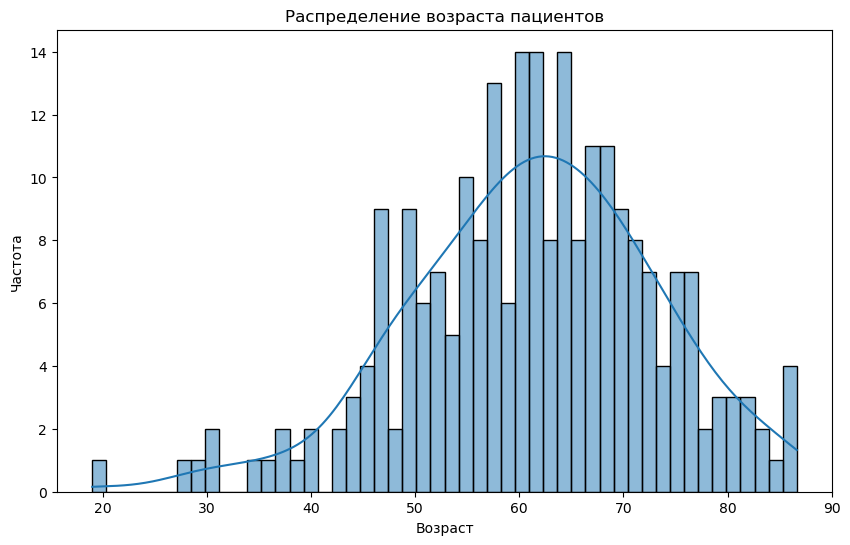

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(survival_info_df['Age'], bins=50, kde=True)
plt.title('Распределение возраста пациентов')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(False)
plt.show()

### Визуализация случайного среза

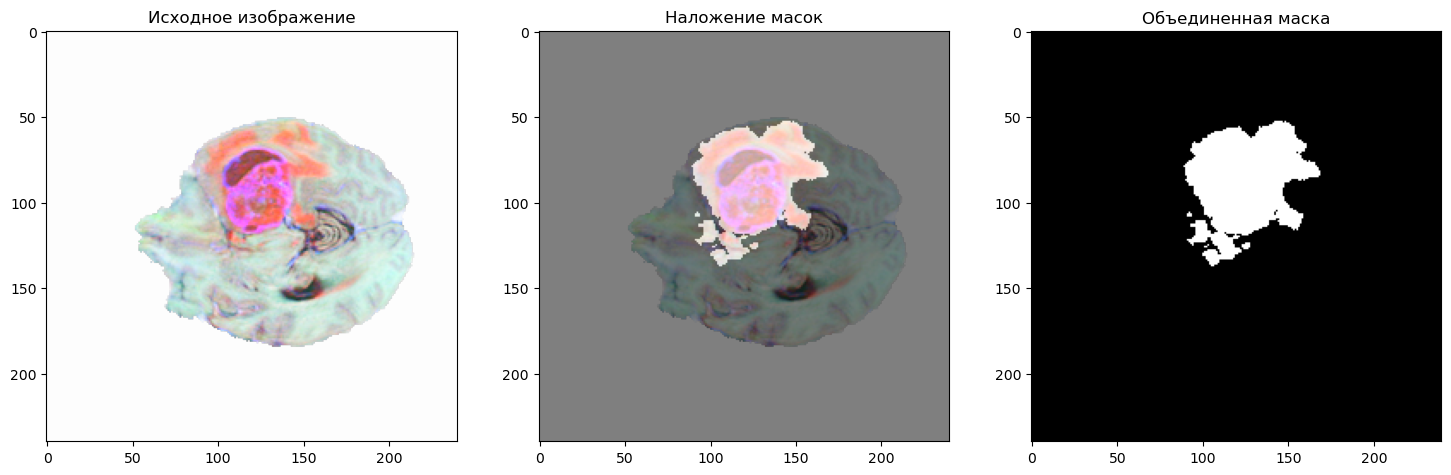

In [34]:
volume_id = 1
slice_id = 60
file_path = os.path.join(data_path, f"volume_{volume_id}_slice_{slice_id}.h5")

image, mask = get_slice(file_path)

mask_combined = combine_mask(mask)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Исходное изображение
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Исходное изображение")
axes[0].grid(False)

# Наложение маски
axes[1].imshow(image, cmap='gray')
axes[1].imshow(mask_combined, cmap='gray', alpha=0.5)
axes[1].set_title("Наложение масок")
axes[1].grid(False)

# Объединённая маска
axes[2].imshow(mask_combined, cmap='gray')
axes[2].set_title("Объединенная маска")
axes[2].grid(False)

plt.show()

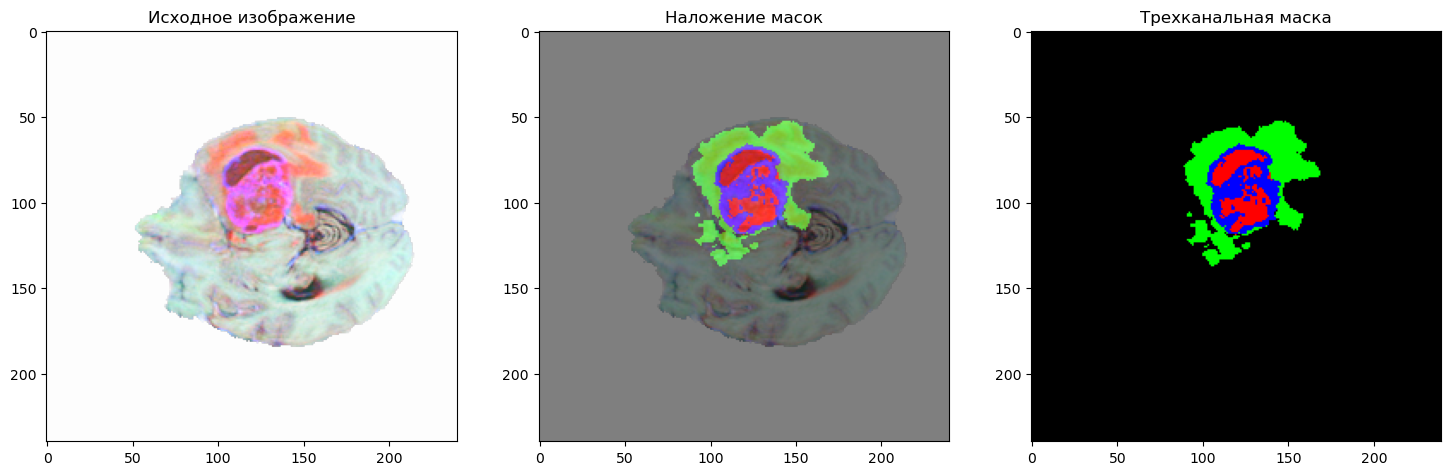

In [35]:
# RGB-представление маски

mask_rgb = combine_rgb_mask(mask)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Исходное изображение
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Исходное изображение")
axes[0].grid(False)

# Наложение маски
axes[1].imshow(image, cmap='gray')
axes[1].imshow(mask_rgb, alpha=0.5)
axes[1].set_title("Наложение масок")
axes[1].grid(False)


# Маска
axes[2].imshow(mask_rgb)
axes[2].set_title("Трехканальная маска")
axes[2].grid(False)

plt.show()

### Аугментация данных

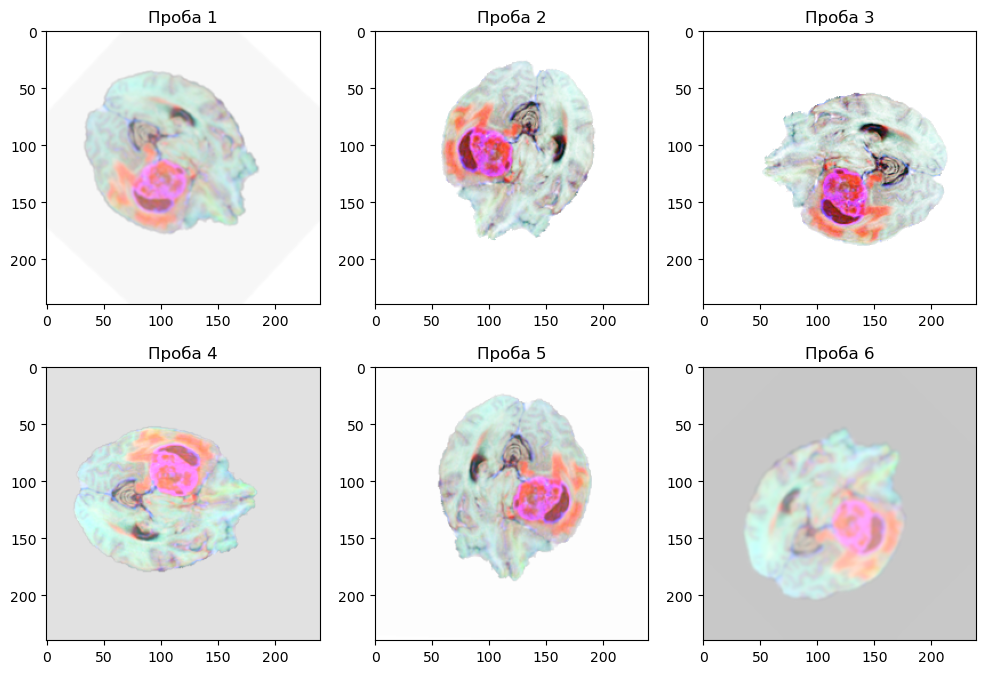

In [36]:
transform = A.Compose([
    A.RandomScale(scale_limit=(0.8, 1.2), p=0.5),
    A.Rotate(limit=180, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.GridDistortion(
        num_steps=5, 
        distort_limit=0.2, 
        p=0.3
    ),
    A.Resize(height=240, width=240),
    
    A.RandomBrightnessContrast(
        brightness_limit=(-0.4, 0.4), 
        contrast_limit=(-0.3, 0.3), 
        p=0.8
    ),
    A.RandomGamma(gamma_limit=(70, 130), p=0.3),
    
    # A.GaussNoise(std_range=(0.02, 0.1), p=0.4),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
# ], additional_targets={'mask': 'mask'})
])

# Пробы аугментации на одном изображении

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

image, mask = get_slice(file_path)
mask = combine_rgb_mask(mask)

for i in range(6):
    augmented = transform(image=image, mask=mask)
    axes[i//3, i%3].imshow(augmented['image'], cmap='gray')
    axes[i//3, i%3].set_title(f"Проба {i+1}")
    axes[i//3, i%3].grid(False)
plt.show()

D:\Datasets\BraTS2020_training_data\content\data\volume_1_slice_60.h5


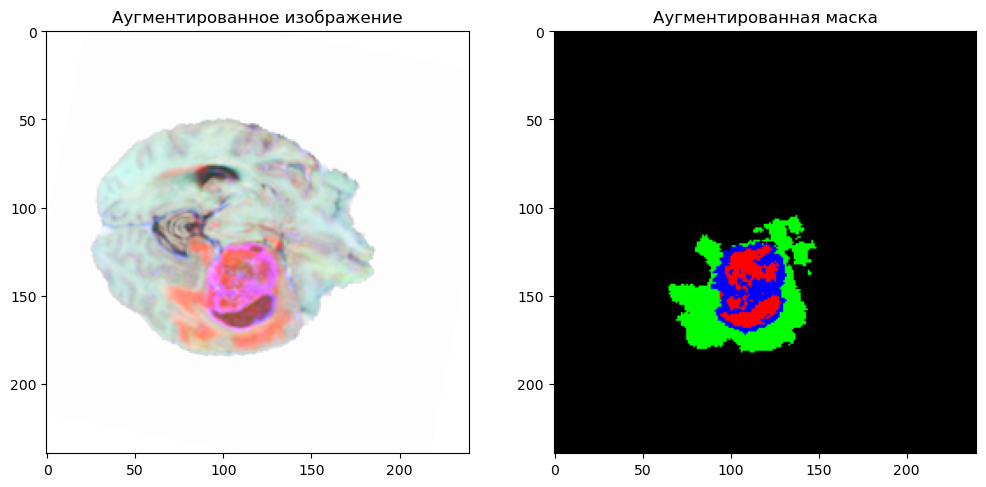

In [37]:
# Аугментация изображения с маской

print(file_path)
image, mask = get_slice(file_path)
mask = combine_rgb_mask(mask)

augmented = transform(image=image, mask=mask)
img_aug = augmented['image']
mask_aug = augmented['mask']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_aug, cmap='gray')
axes[0].set_title("Аугментированное изображение")

axes[1].imshow(mask_aug, cmap='gray')
axes[1].set_title("Аугментированная маска")

plt.show()

In [40]:
# Аугментация всего датасета

transform = A.Compose([
    A.RandomScale(scale_limit=(0.8, 1.2), p=0.5),
    A.Rotate(limit=180, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.GridDistortion(
        num_steps=5, 
        distort_limit=0.2, 
        p=0.3
    ),
    A.Resize(height=240, width=240),
    
    A.RandomBrightnessContrast(
        brightness_limit=(-0.4, 0.4), 
        contrast_limit=(-0.3, 0.3), 
        p=0.8
    ),
    A.RandomGamma(gamma_limit=(70, 130), p=0.3),
    
    # A.GaussNoise(std_range=(0.02, 0.1), p=0.4),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
# ], additional_targets={'mask': 'mask'})
])

data_path = r"D:\Datasets\BraTS2020_training_data\content\data"
output_path = r"D:\Datasets\BraTS2020_training_data\content\data_augmented"
os.makedirs(os.path.join(output_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'masks'), exist_ok=True)

# volume_id = 3 - 1

for volume_id in range(3):
    for slice_id in range(155):
        file_path = os.path.join(data_path, f"volume_{volume_id + 1}_slice_{slice_id}.h5")
        print(file_path)
        img, mask = get_slice(file_path)
        mask = combine_rgb_mask(mask)
        # plt.imshow(img, cmap='gray')
    
        augmented = transform(image=img, mask=mask)
        img_aug = augmented['image']
        mask_aug = augmented['mask']
        # plt.imshow(mask_aug, cmap='gray')
    
        img_name = f"volume_{volume_id + 1}_slice_{slice_id}_aug.png"
        mask_name = f"volume_{volume_id + 1}_slice_{slice_id}_aug_mask.png"
        
        cv2.imwrite(os.path.join(output_path, 'images', img_name), img_aug)
        print(img_name)
        cv2.imwrite(os.path.join(output_path, 'masks', mask_name), mask_aug)
        print(mask_name)

print("Аугментация завершена")

D:\Datasets\BraTS2020_training_data\content\data\volume_1_slice_0.h5
volume_1_slice_0_aug.png
volume_1_slice_0_aug_mask.png
D:\Datasets\BraTS2020_training_data\content\data\volume_1_slice_1.h5
volume_1_slice_1_aug.png
volume_1_slice_1_aug_mask.png
D:\Datasets\BraTS2020_training_data\content\data\volume_1_slice_2.h5
volume_1_slice_2_aug.png
volume_1_slice_2_aug_mask.png
D:\Datasets\BraTS2020_training_data\content\data\volume_1_slice_3.h5
volume_1_slice_3_aug.png
volume_1_slice_3_aug_mask.png
D:\Datasets\BraTS2020_training_data\content\data\volume_1_slice_4.h5
volume_1_slice_4_aug.png
volume_1_slice_4_aug_mask.png
D:\Datasets\BraTS2020_training_data\content\data\volume_1_slice_5.h5
volume_1_slice_5_aug.png
volume_1_slice_5_aug_mask.png
D:\Datasets\BraTS2020_training_data\content\data\volume_1_slice_6.h5
volume_1_slice_6_aug.png
volume_1_slice_6_aug_mask.png
D:\Datasets\BraTS2020_training_data\content\data\volume_1_slice_7.h5
volume_1_slice_7_aug.png
volume_1_slice_7_aug_mask.png
D:\Datas

In [39]:
# output_path = r"D:\Datasets\BraTS2020_training_data\content\data_augmented"
# os.makedirs(output_path, exist_ok=True)

# for volume_id in range(3):
#     for slice_id in range(155):  # Проходим по всем слоям
#         file_path = os.path.join(data_path, f"volume_{volume_id + 1}_slice_{slice_id}.h5")
#         img, mask = get_slice(file_path)
        
#         # Применяем аугментации
#         augmented = transform(image=img, mask=mask)  # Исправлено: image=img вместо image=image
#         img_aug = augmented['image']
#         mask_aug = augmented['mask']

#         # Правильное масштабирование для изображения
#         if img_aug.dtype == np.float32:
#             if img_aug.max() <= 1.0:  # Если данные нормализованы [0, 1]
#                 img_aug = (img_aug * 255).astype(np.uint8)
#             else:  # Если данные в другом диапазоне (например, [-1, 1])
#                 img_aug = ((img_aug + 1.0) * 127.5).astype(np.uint8)
        
#         # Для масок используем прямое преобразование
#         mask_aug = mask_aug.astype(np.uint8) * 255  # Активация всех классов

#         # Сохранение с проверкой размерности
#         if len(img_aug.shape) == 2:
#             cv2.imwrite(os.path.join(output_path, f"volume_{volume_id + 1}_slice_{slice_id}_aug.jpg"), img_aug)
#             cv2.imwrite(os.path.join(output_path, f"volume_{volume_id + 1}_slice_{slice_id}_aug_mask.png"), mask_aug)
#         else:
#             cv2.imwrite(os.path.join(output_path, f"volume_{volume_id + 1}_slice_{slice_id}_aug.jpg"), cv2.cvtColor(img_aug, cv2.COLOR_RGB2BGR))

# print("Аугментация завершена")

## Цитирование

[1] B. H. Menze, A. Jakab, S. Bauer, J. Kalpathy-Cramer, K. Farahani, J. Kirby, et al. "The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)", IEEE Transactions on Medical Imaging 34(10), 1993-2024 (2015) DOI: 10.1109/TMI.2014.2377694

[2] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J.S. Kirby, et al., "Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features", Nature Scientific Data, 4:170117 (2017) DOI: 10.1038/sdata.2017.117

[3] S. Bakas, M. Reyes, A. Jakab, S. Bauer, M. Rempfler, A. Crimi, et al., "Identifying the Best Machine Learning Algorithms for Brain Tumor Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge", arXiv preprint arXiv:1811.02629 (2018)

[4] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J. Kirby, et al., "Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-GBM collection", The Cancer Imaging Archive, 2017. DOI: 10.7937/K9/TCIA.2017.KLXWJJ1Q

[5] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J. Kirby, et al., "Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-LGG collection", The Cancer Imaging Archive, 2017. DOI: 10.7937/K9/TCIA.2017.GJQ7R0EF